# Numerical Gradients with Neural Nets

As before, first we will get things rocking and rolling with Cody's old data at h11=15.

Our goal will be to have a simple FFNN construct the random matrix for us. This should require only a few modifications of the old code. I'll track the changes, for simplicity:

- change random matrix to be the output of a neural network
- change sample to use random_matrix() (before was random_wishart()), make only numdraws and nn dep
- added AAtranspose method

## Wasserstein_distance

First we must adapt scipy's wasserstein_distance function utilize torch instead of numpy

In [1]:
from torchsearchsorted import searchsorted
import numpy as np
from scipy.stats import wasserstein_distance
import seaborn as sns
from matplotlib import pyplot as plt
import torch

# set up test nn
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else: device = torch.device('cpu')
    
print device    
    
test_nn = torch.nn.Sequential(
    torch.nn.Linear(1,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,225)
).to(device)


real_eigs_cody = np.loadtxt("ppo2/h11=15.txt")
real_eigs_cody = torch.Tensor(real_eigs_cody).to(device)

def remove_nan(t):
    nan = torch.isnan(t[0])
    o = torch.tensor([])
    for idx,p in enumerate(nan):
        #print p, o
        if p == 0:
            o = torch.cat((o,torch.tensor([t[0][idx]])))
        else:
            o = torch.cat((o,torch.tensor([0.0])))
    return torch.tensor([list(o)])

def _cdf_distance(p, u_values, v_values):
    #print "input", u_values, v_values
    #print '\nsorter'
    u_sorter = torch.argsort(u_values).to(device)
    v_sorter = torch.argsort(v_values).to(device)

    #print 'allvals'
    all_values = torch.cat((u_values, v_values))
    all_values, _ = all_values.sort()
    #print'av',all_values

#     # Compute the differences between pairs of successive values of u and v.
    deltas = all_values[1:] - all_values[:-1]  # replaces call to np.diff
#     print 'searchsorted'
#     u_cdf_indices = searchsorted(torch.tensor([list([u_values[u_sorter]][0])]), torch.tensor([list([all_values[:-1]][0])])).to(device)
#     v_cdf_indices = searchsorted(torch.tensor([list([v_values[v_sorter]][0])]), torch.tensor([list([all_values[:-1]][0])])).to(device)
#     #print 'ucdfind', u_cdf_indices

    u1,u2 = remove_nan(torch.tensor([list([u_values[u_sorter]][0])])), remove_nan(torch.tensor([list([all_values[:-1]][0])]))
    u_cdf_indices = searchsorted(u1,u2).to(device)
    v1, v2 = remove_nan(torch.tensor([list([v_values[v_sorter]][0])])),remove_nan(torch.tensor([list([all_values[:-1]][0])]))
    v_cdf_indices = searchsorted(v1,v2).to(device)

    #print 'cdf'
    # Calculate the CDFs of u and v using their weights, if specified.
    u_cdf = u_cdf_indices / u_values.shape[0]
    v_cdf = v_cdf_indices / v_values.shape[0]

    #print 'uv', u_cdf, v_cdf

    #print 'check1', deltas
    #print 'sum and multiply'
    
    return torch.sum(torch.abs(u_cdf-v_cdf)*deltas)
    return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))
    #print 'return from loss'
    return torch.pow(torch.sum(torch.pow(torch.abs(u_cdf - v_cdf), p) * deltas), 1 / p)


def wasserstein_distance(u, v):
    return _cdf_distance(1, u, v)


print wasserstein_distance(real_eigs_cody,real_eigs_cody)


cuda:0
tensor(0., device='cuda:0')


In [2]:
import pandas as pd
import datetime

def initial_vars(nmod):
    return [1./np.float(nmod)**(1./2.) for i in range(nmod + 2)]

def AAtranspose(A): # computes AAtrans for a matrix A
    return torch.mm(A,torch.transpose(A,0,1))

def random_matrix(nn=test_nn): # pos def metric
    mat = nn(torch.rand(1).to(device)).reshape(15,15)
    return AAtranspose(mat)

def sample(numdraws,nn=test_nn):
    evals = torch.tensor([]).to(device)
    #print 'numdraws'
    for num in range(numdraws):
        #print num
        evals = torch.cat((evals,torch.symeig(random_matrix(nn=nn),eigenvectors=True)[0]))
    #    print 'end eval'
    return evals

def wasserstein_loss(numdraws=300, numspectra=1, real_eigs = real_eigs_cody,nn=test_nn): # h11 = len(vars)-2
    return wasserstein_distance(torch.log10(sample(numdraws,nn=nn)),real_eigs)
    #return torch.mean([wasserstein_distance(sample(numdraws,nn=nn).cpu().detach().numpy(),real_eigs.cpu().detach().numpy()) for i in range(numspectra)])

def gradient_descent(num_epochs=1000, lr = .001, logplot = True, real_eigs = real_eigs_cody, opt = torch.optim.Adam, hidden_dim = 1500):
        
    loss, numsteps = 1e6, 0
    best = loss
    
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else: device = torch.device('cpu')
        
    train_nn = torch.nn.Sequential(
        torch.nn.Linear(1,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Dropout(.05),
        torch.nn.Linear(hidden_dim,225)
    ).to(device)
    optimizer = opt(train_nn.parameters(), lr=lr)    
        
    # train
    loss, numsteps = 1e6, 0
    best = loss
    lastlossplotted = loss
    
    runningloss = 0
    for epoch in range(num_epochs):

        optimizer.zero_grad()
        #print 'compute loss'
        loss = wasserstein_loss(nn=train_nn, real_eigs = real_eigs)
        #print "epoch", epoch, "loss", loss
        #print 'backprop'
        loss.backward()
        #print 'step'
        optimizer.step()
        #print 'end step'
    
        runningloss += loss
    
        # prints and trivial  updates
        if loss < best:
            best = loss
            print "new best:", loss
            if lastlossplotted - best > .1:
                lastlossplotted = best
                
                with torch.no_grad():
                    if logplot:
                        sns.distplot([torch.log10(k) for k in real_eigs.cpu()], kde=False, label='10', norm_hist = True)
                        samp = [float(torch.log10(k)) for k in sample(1000).cpu()]
                        #print samp
                        df = pd.DataFrame(samp)
                        #print [torch.log10(k) for k in sample(300).cpu()]
                        sns.distplot(df.dropna(), kde=False, label='10', norm_hist = True)
                    else:
                        sns.distplot([k for k in real_eigs.cpu()], kde=False, label='10', norm_hist = True)
                        samp = [float(k) for k in sample(300).cpu()]
                        df = pd.DataFrame(samp)
                        sns.distplot(df.dropna(), kde=False, label='10', norm_hist = True)
                
                plt.show()
        
        if numsteps % 10 == 0: 
            print "steps: {} \t avg loss last 10: {}".format(numsteps,runningloss/10), datetime.datetime.now()
            runningloss = 0
        numsteps += 1

    return train_nn

steps: 0 	 avg loss last 10: nan 2019-10-14 14:25:24.948367
new best: tensor(11.3604, device='cuda:0', grad_fn=<SumBackward0>)


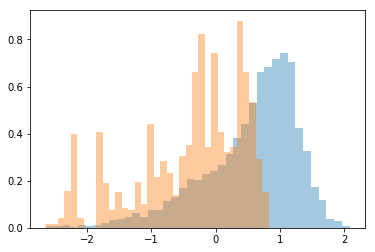

new best: tensor(11.3603, device='cuda:0', grad_fn=<SumBackward0>)
steps: 10 	 avg loss last 10: nan 2019-10-14 14:25:45.339508
new best: tensor(11.3543, device='cuda:0', grad_fn=<SumBackward0>)
new best: tensor(11.3503, device='cuda:0', grad_fn=<SumBackward0>)
steps: 20 	 avg loss last 10: nan 2019-10-14 14:26:04.451892
steps: 30 	 avg loss last 10: nan 2019-10-14 14:26:23.356416
steps: 40 	 avg loss last 10: nan 2019-10-14 14:26:42.151518
steps: 50 	 avg loss last 10: nan 2019-10-14 14:27:00.941035
steps: 60 	 avg loss last 10: nan 2019-10-14 14:27:19.735527
steps: 70 	 avg loss last 10: nan 2019-10-14 14:27:38.521702
new best: tensor(11.3489, device='cuda:0', grad_fn=<SumBackward0>)
steps: 80 	 avg loss last 10: nan 2019-10-14 14:27:57.288587
steps: 90 	 avg loss last 10: nan 2019-10-14 14:28:16.445803
steps: 100 	 avg loss last 10: nan 2019-10-14 14:28:35.458642
steps: 110 	 avg loss last 10: nan 2019-10-14 14:28:54.650577
new best: tensor(11.3452, device='cuda:0', grad_fn=<SumBack

new best: tensor(11.2600, device='cuda:0', grad_fn=<SumBackward0>)


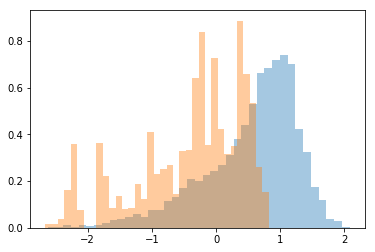

steps: 800 	 avg loss last 10: 11.2635240555 2019-10-14 14:51:58.626400
steps: 810 	 avg loss last 10: 11.263633728 2019-10-14 14:52:18.477731
steps: 820 	 avg loss last 10: 11.2629299164 2019-10-14 14:52:37.847616
steps: 830 	 avg loss last 10: 11.2640171051 2019-10-14 14:52:57.418468
new best: tensor(11.2599, device='cuda:0', grad_fn=<SumBackward0>)
steps: 840 	 avg loss last 10: 11.2629213333 2019-10-14 14:53:16.706357
steps: 850 	 avg loss last 10: nan 2019-10-14 14:53:35.930277
steps: 860 	 avg loss last 10: nan 2019-10-14 14:53:55.953083
new best: tensor(11.2590, device='cuda:0', grad_fn=<SumBackward0>)
steps: 870 	 avg loss last 10: nan 2019-10-14 14:54:15.492495
steps: 880 	 avg loss last 10: 11.2623853683 2019-10-14 14:54:35.083390
steps: 890 	 avg loss last 10: 11.2628755569 2019-10-14 14:54:54.231710
new best: tensor(11.2578, device='cuda:0', grad_fn=<SumBackward0>)
steps: 900 	 avg loss last 10: nan 2019-10-14 14:55:13.775127
steps: 910 	 avg loss last 10: 11.2627296448 201

In [ ]:
out = gradient_descent(num_epochs = 1000000,lr=.000001,hidden_dim = 1000)  

In [ ]:
out = gradient_descent(num_epochs = 1000000,lr=.00001)  

In [ ]:
gradient_descent(num_epochs = 5000,lr=.001)     

In [ ]:
gradient_descent(initial_vars(10), gradwidth=.01, lr=.0001, logplot = False)  

# Systematic Calabi-Yau Data

In [ ]:
CY_eigs = {
          10: np.loadtxt("KS4/h11_10_eigs.txt"),
          20: np.loadtxt("KS4/h11_20_eigs.txt"),
          30: np.loadtxt("KS4/h11_30_eigs.txt"),
          40: np.loadtxt("KS4/h11_40_eigs.txt"),
          50: torch.tensor(np.loadtxt("KS4/h11_50_eigs.txt")).to(device)
          }

In [ ]:
#gradient_descent(initial_vars(10), num_iter=10000, gradwidth=.01, lr=.0001, real_eigs = CY_eigs[10]) 

In [ ]:
gradient_descent(num_epochs=5000, lr=.001, real_eigs = CY_eigs[50]) 

In [ ]:
np.loadtxt("KS4/h11_50_eigs.txt")